In [3]:
# import libaries
import matplotlib.pyplot as plt
from IPython import display
import matplotlib as mpl
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import math
import json
import numpy as np
from sqlalchemy import create_engine
import bisect
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import time

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


In [23]:
changed_reservations = {}

In [24]:
changed_reservations[200]

KeyError: 200

# Enviorment (will be replaced with Python package later)

In [39]:
class CarsharingEnv(gym.Env):
    def __init__(self, stations, vehicle_information, episode_len = 24, dt=0.25, 
                 cancellation_penalty = 100, penalty_per_kwh = 0.25, v2g = True, 
                 v2g_demand_event = 500, v2g_max_duration = 3.0, v2g_penalty = 10000, 
                 v2g_probability_charging_event = 0.5, v2g_probability_discharging_event = 0.5, 
                 v2g_morning_time_period = [6.0, 9.0, 10.75], v2g_noon_time_period = [11.0, 14.0, 16.0], 
                 v2g_evening_time_period = [16.25, 19.0, 24.0], v2g_reward = 2000,
                 planned_bookings = True, precomputed_bookings = True, max_distance_car_assingment = 5000, plot_state = True):
        """
        Initialization of simulation enviorment for car-sharing charging and/or vehicle-to-grid (V2G) optimization.
        
        Parameters
        ----------
        stations: Geopandas Geodataframe
            Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.
        vehicle_information: Pandas Dataframe
            Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.
        episode_len: int, optional
            Length of one episode in hours, by default 24.
        dt: float, optional
            Time step size in hours, by default 0.25 (a quarter hour).
        cancellation_penalty: int, optional
            Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.
        penalty_per_kwh: int, optional
            Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.
        v2g: boolean, optional
            Boolean indicating if V2G events take place, by default True.
        v2g_demand_event: int, optional
            Energy demand during V2G event in kWh per time step (dt), by default 500.
        v2g_max_duration: int, optional
            Maximum duration of V2G charging or discharging event in hours, by default 3.
        V2G_penalty: int, optional
            Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.
        v2g_probability_charging_event: float, optional
            Probability that a charging event will take place around noon, by default 0.5.
        v2g_probability_discharging_event: float, optional
            Probability that a discharging event will take place in the morning or evening, by default 0.5.
        v2g_morning_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the morning, by default 6.0 (6 AM).
                             2) last possible time (hours) for starting v2g discharging event in the morning, by default 9.0 (9 AM).
                             3) last possible timestamp for v2g discharging operation, by default 10.75 (10:45 AM).
        v2g_noon_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g charging event at noon, by default 11.0 (11 AM).
                             2) last possible time (hours) for starting v2g charging event at noon, by default 14.0 (2 PM).
                             3) last possible timestamp for v2g charging operation, by default 16.0 (4 PM).
        v2g_evening_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the evening, by default 16.25 (4:15 PM).
                             2) last possible time (hours) for starting v2g discharging event in the evening, by default 19.0 (7 PM).
                             3) last possible timestamp for v2g charging operation, by default 24 (00:00 AM, next day).
        v2g_reward: int, optional
            Revenue during v2g operations per timestep in CHF, by default 2000 CHF.
        planned_bookings: boolean, optional
            Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.
        precomputed_bookings: boolean, optional
            Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.
        max_distance_car_assingment: int, optional
            Maximum search distance in meter for car-assingment problem, by default 5000.
        plot_state: boolean, optional
            Plot current state of enviorment or not, by default True.
        ----------
        Observation space: 5 parts:
        1) Location for each car (four options):
            - Station number (1000-5000)
            - Reservation number (2x'xxx'xxx) during trip
            - Reservation number (3x'xxx'xxx) during relocation
            - -1 if car is not available
        2) State of charge (SOC) for each vehicle (between 0 and 1).
        3) Timestamp of the next planned booking for each car (discrete between 0 and self.episode_len).
        4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
        5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
        Remark: States 3) and 4) are only included if the variable "planned_bookings" is True.
        ----------
        Action space: 3 actions for each car:
        1) 0 = do nothing.
        2) 1 = charging.
        3) 3 = discharging (V2G).
        """
 
        # environment settings
        self.dt = dt
        self.episode_len = int(episode_len / self.dt) 
        self.planned_bookings = planned_bookings
        self.precomputed_bookings = precomputed_bookings
        self.max_distance_car_assingment = max_distance_car_assingment
        self.plot_state = plot_state
        
        # stations in system
        self.stations = stations
        
        # vehicle information
        self.vehicles_id = vehicle_information["vehicle_no"]
        self.nr_vehicles = len(self.vehicles_id)
        self.chariging_power = np.full_like(vehicle_information["charge_power"], min(vehicle_information["charge_power"])) 
        self.battery_capacities = vehicle_information["battery_capacity"] 
        self.vehicle_type = vehicle_information["vehicle_category"] 
        
        # V2G 
        self.v2g = v2g
        self.v2g_demand_event = v2g_demand_event
        self.v2g_max_duration = v2g_max_duration / self.dt
        self.v2g_penalty = v2g_penalty
        self.v2g_probability_charging_event = v2g_probability_charging_event
        self.v2g_probability_discharging_event = v2g_probability_discharging_event
        self.v2g_morning_time_period = v2g_morning_time_period
        self.v2g_noon_time_period = v2g_noon_time_period
        self.v2g_evening_time_period = v2g_evening_time_period
        self.v2g_reward = v2g_reward
        
        # penalties
        self.cancellation_penalty = cancellation_penalty
        self.penalty_per_kwh = penalty_per_kwh
        
        # define observation space:
        if self.planned_bookings is True:
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0, -1, -1] * self.nr_vehicles),
                    high=np.array([9999999, 1, 96, 100] * self.nr_vehicles),
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
        else: 
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0] * self.nr_vehicles),
                    high=np.array([9999999, 1] * self.nr_vehicles)
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
    
        # action space
        self.action_space = spaces.MultiDiscrete([3 for _ in range(self.nr_vehicles)])
        
        # define state boundaries for slicing state array
        # locations upper bound
        self.locations_upper = self.nr_vehicles
        # soc upper bound
        self.soc_upper = 2*self.nr_vehicles
        if planned_bookings is True:
            # planned reservations, upper bound:
            self.reservation_time_upper = self.nr_vehicles * 3
            # v2g, lower bound:
            self.v2g_lower = self.nr_vehicles * 4
        else:
            # v2g, lower bound:
            self.v2g_lower = self.nr_vehicles * 2
            
    def reset(self, daily_data, reservations, planned_reservations = None, planned_durations = None):
        """
        Reset environment to beginning of new episode.
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        planned_reservations: Pandas DataFrame, optional
            Timestamps of next planned reservations for each car, by default None.
        planned_durations: Pandas DataFrame, optional
            Durations of next planned reservations for each car, by default None.
        
        Returns
        ----------
        self.state: numpy ndarray
            The reset state of the environment at the first time step. It includes the following information for each car:
            1) Location (four options):
                - Station number (1000-5000)
                - Reservation number (2x'xxx'xxx) during trip
                - Reservation number (3x'xxx'xxx) during relocation
                - -1 if the car is not available
            2) State of charge (SOC) for each vehicle (between 0 and 1).
            3) Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
            4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
            5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
            Note: The information in 3) and 4) is included only if the variable "planned_bookings" is True.
        """
        
        # set time to 0
        self.t = 0
        
        # reset reward lists 
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list_v2g = []
        self.reward_list = []
        
        # reset old state
        self.state_old = np.zeros(self.nr_vehicles * 4 + 1)
        
        # reset planned reservations:
        self.planned_reservations_car = {key: [] for key in self.vehicles_id}
        
        # get random v2g events
        self.get_random_v2g_events()
        
        # reset changes discrete table
        self.changed_vehicles = {}
        
        # reset changed reservations
        self.changed_reservations = {key: 0 for key in range(self.nr_vehicles)}

        ### initialize state at t = 0 ###
        # 1) car locations (three options)
        car_locations = daily_data.iloc[:,0].values
        
        # 2) SOC (state of charge) ##
        #car_SOC = np.random.rand(self.nr_vehicles) # random values between 0-100%
        #car_SOC = np.zeros(self.nr_vehicles) # all car batteries empty (0%)
        #car_SOC = np.full((self.nr_vehicles,), 0.2) # all car batteries at 20%
        #car_SOC = np.random.uniform(low=0.5, high=1, size=self.nr_vehicles) # All cars randomly between 50-100%
        np.random.seed(42)
        rng = np.random.RandomState(42)
        car_SOC = rng.uniform(low=0.5, high=1, size=self.nr_vehicles)
        
         # state 5) Binary V2G event
        v2g_event = np.array([0])
 
        # final state with planned bookings
        if self.planned_bookings is True:
            # 3) timestamp of next planned reservation 
            # 4) Duration of next planned reservation
            if self.precomputed_bookings is True:
                # load precomputed state
                next_reservation = planned_reservations.iloc[:,0].values
                duration_next_reservation = planned_durations.iloc[:,0].values
            else:
                # calculate state
                next_reservation, duration_next_reservation = self.update_reservation_state(reservations, True)

            # concatinate states 1-5
            self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation, v2g_event])
        else:
            # concatinate states 1-5 without planned boookings (state 3,4)
            self.state = np.concatenate([car_locations, car_SOC, v2g_event])
        
        # save energy at beginning of episode (for reward calculation)
        self.energy_beginning = sum(car_SOC * self.battery_capacities)

        return self.state

    def get_random_v2g_events(self):
        """
        Samples random V2G events during the day. A discharging event can take place in the morning and evening, a charging
        event at noon.
        """
        
        # initalize with no occurance
        self.v2g_discharing_morning_start = -1
        self.v2g_discharing_morning_end = -1
        self.v2g_charing_noon_start = -1
        self.v2g_charing_noon_end = -1
        self.v2g_discharing_evening_start = -1
        self.v2g_discharing_evening_end = -1
        
        # sample random v2g event
        if self.v2g is True:
            # morning discharging event:
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                # get random start time
                self.v2g_discharing_morning_start = round(random.uniform(self.v2g_morning_time_period[0], self.v2g_morning_time_period[1]) / 0.25) * 0.25 / self.dt
                # get random end time
                self.v2g_discharing_morning_end = min(self.v2g_morning_time_period[2] / self.dt, self.v2g_discharing_morning_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # noon charging event
            if int(random.random() < self.v2g_probability_charging_event) == 1:
                # get random start time
                self.v2g_charing_noon_start = round(random.uniform(self.v2g_noon_time_period[0], self.v2g_noon_time_period[1]) / 0.25) * 0.25 / self.dt
                # get random end time
                self.v2g_charing_noon_end = min(self.v2g_noon_time_period[2] / self.dt, self.v2g_charing_noon_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # evening discharging event
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                # get random start time 
                self.v2g_discharing_evening_start = round(random.uniform(self.v2g_evening_time_period[0], self.v2g_evening_time_period[1]) / 0.25) * 0.25 / self.dt
                # get random end time
                self.v2g_discharing_evening_end = min(self.v2g_evening_time_period[2]/ self.dt,self.v2g_discharing_evening_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
        
        return
    
    def update_reservation_state(self, reservations, reset):
        """
        Caculates part of state (next planned reservation and duration for each car). Only used if planned_bookings is True
        and precomputed_bookings is False. Computationally very expensive.
        
        Parameters
        ----------
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        reset: boolean, optional
            Boolean indicating whether to reset the environment or not (only at beginning of new episode).
            
        Returns
        ----------
        next_reservation : numpy ndarray
            Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
        duration_next_reservation : numpy ndarray
            Duration of the next planned booking (measured in the number of time steps of length self.dt).
        """

        # initalize variables if function used during reset of environment
        if reset is True:
            time = 0
            next_reservation = np.ones(self.nr_vehicles) * -1
            duration_next_reservation = np.ones(self.nr_vehicles) * -1
            
        # get current state of next planned reservations (timestamp and duration)
        else:
            time = self.t + 1
            next_reservation = self.state[self.soc_upper : self.reservation_time_upper]
            duration_next_reservation = self.state[self.reservation_time_upper :self.v2g_lower]
            
        # filter reservations: 
        # bookings before t = 0 have value syscreatedate_daytime = 0
        reservations_t =  reservations[reservations["syscreatedate_daytime"] == time]
        
        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            # get reservation of current car
            current_car = reservations_t[reservations_t["vehicle_no"] == vehicle_id]

            # remove reservations that are in past
            if len(self.planned_reservations_car[vehicle_id]) != 0 and int(self.planned_reservations_car[vehicle_id][0][0]) <= self.t:
                self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

            # case if no new reservation found
            if len(current_car) == 0:
                
                # if current state's reservation is in the past 
                if next_reservation[count] <=  self.t and next_reservation[count] != -1:
                    
                    # check for planned reservations saved in the past
                    if len(self.planned_reservations_car[vehicle_id]) != 0:
                        # save reservation timestamp
                        next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                        # save reservation duration
                        duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                        # remove reservation from dict with planned reservations
                        self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

                    else:
                        # assign -1 for no planned reservation
                        next_reservation[count] = -1
                        duration_next_reservation[count] = -1
                
                # continue with next car
                count +=1
                continue

            for i in range(0,len(current_car)):    
                
                # get timestamp and duration of next planned reservation
                reservation_time = current_car["reservationfrom_daytime"].iloc[i]
                reservation_duration = current_car["reservation_duration"].iloc[i]
                
                # case if function is used during reset of enviroment
                if reset is True and i == 0:
                    
                    # save directly next reservation 
                    # save timestamp of next reservation
                    next_reservation[count] = reservation_time

                    # save reservation duration
                    duration_next_reservation[count] = reservation_duration
                
                else: 
                    # save found reservation environment in dict
                    new_reservation = [reservation_time, reservation_duration]
                    
                    # remain order in dict (nearest reservation in first index)
                    index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])
                    
                    # save timestamp and duration of new but later reservations in dict
                    self.planned_reservations_car[vehicle_id].insert(index, new_reservation)

            # update only if reservation is before last planned reservation
            if  reset is False and self.planned_reservations_car[vehicle_id][0][0] <  next_reservation[count]:
                # save timestamp of next reservation
                next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                # save reservation duration
                duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                # remove reservation from dict
                self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]
                
            count += 1
        
        return next_reservation, duration_next_reservation
    
    def cancel_trips_low_SOC(self, daily_data, reservations):
        """
        Checks if car have enough SOC for serving trip. If not, the reservation will assinged to a alternative available car
        if possible. In those cases, a distant dependent penalty factor will be calculated.
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        
        Returns
        ----------
        penalty_counter: int
            Total factor of penalty for timestep.    
        """            
        # check if car booked or not (start of booking)
        on_trip = self.state[:self.locations_upper] > 1000000
        on_trip_cond2 = self.state[:self.locations_upper] <= 30000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start & on_trip_cond2

        # array with 0 for all car that do not start a new trip, otherwise SOC value
        soc_needed = np.zeros(len(result))

        # get reservation numbers for cars starting trips
        reservation_nos = self.state[:self.locations_upper][result]
        trip_indices = result.nonzero()[0]

        # find reservations in bulk to avoid repeated searches
        valid_reservations = reservations[~(reservations["reservation_no"] >= 30000000)].set_index("reservation_no")

        # set SOC values for relevant cars
        soc_needed[trip_indices] = valid_reservations.loc[reservation_nos]["required_soc"].values / 100
    
        # calculate difference between SOC of car at the moment and needed SOC for starting the trip
        difference_energy = self.state[self.locations_upper:self.soc_upper] - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars (previous timestamps SOC minus SOC needed for trip)
        self.state[self.locations_upper:self.soc_upper] = (self.state[self.locations_upper:self.soc_upper] - soc_needed * not_cancelled_trips_int) 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        
        ### remove cancelled booking from discrete tables (if reservation is cancelled, the car is again available) ###
        ### assign bookings to other cars if possible ###
        
        # sum penalty factor of cancellations, used for reward penalty
        penalty_counter = 0
    
        # iterate over indices of cars with cancelled reservations
        for index in indices:
            found = False
            last_station = 0
            #t = self.t
            
            if index == 690:
                print("Car Assingment 690")
                reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[690]) & (reservations["reservation_no"] == daily_data.iloc[690, self.t + 1])]
                print(reservations_of_car["reservation_no"].iloc[0])

            if index == 2037:
                print("Car Assingment 2037")
                reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[2037]) & (reservations["reservation_no"] == daily_data.iloc[2037, self.t + 1])]
                print(reservations_of_car["reservation_no"].iloc[0])
            
            # get reservation information, assign to other car
            reservations_of_car = reservations[reservations["reservation_no"] == daily_data.iloc[index, self.t + 1]]
            
            # if the reservation cannot be found
            if len(reservations_of_car) == 0:
                print("")
                print("Reservation in Discrete table not found in Reservation table")
                print("Car ID")
                print(self.vehicles_id[index])
                print("Reservation_number")
                print(daily_data.iloc[index, self.t + 1])
                continue
                
            car_location = reservations_of_car["start_station_no"].iloc[0]
            reservation_no = reservations_of_car["reservation_no"].iloc[0]
            reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
            penalty, duration, cancelled_reservation_no = self.car_assignment(car_location, daily_data, reservations, index, soc_needed[index], reservation_no, reservation_duration)
            penalty_counter += penalty
             
            # update current state of car with actual location
            self.state[index] = car_location

            # iterate over row in discrete table of given car, remove reservation
            self.changed_vehicles[index] = (car_location, self.t + 1 + duration, cancelled_reservation_no)
        
        # return total cancellation penalty
        return penalty_counter
    
    def car_assignment(self, station_id, daily_data, reservations, index_car, soc_needed, reservation_no, reservation_duration):
        """
        Search alternative, available cars in neigbourhood of cancelled reservation's car.
        
        Parameters
        ----------
        station_id: int
            ID of station with the cancelled reservation.
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        index_car: int
            Index of the car with the cancelled reservaton
        soc_needed: int
            Minimum needed SOC for cancelled trip.

        Returns
        ----------
        penalty_counter: int
            Penalty of single cancelled reservation
        """

        # create local copy of station table
        stations_processing = self.stations.copy()
        
        # get geodata of station with cancelled reservation
        station = stations_processing[stations_processing["station_no"] == station_id]
        
        # get car type of cancelled car
        car_type_cancelled = self.vehicle_type[index_car]
        
        # search available cars at stations in the neigbourhood of the cancelled reservation's car
        solution_found = False
        while solution_found is not True:
            
            # perform the spatial nearest neighbor join for getting nearest station and the distance
            joined = gpd.sjoin_nearest(station, stations_processing, distance_col = "distance_stations", max_distance = self.max_distance_car_assingment)
            
            # no station found within 5km distance
            if len(joined) == 0:
                solution_found = True
                
                # return maximum penalty
                penalty = 1
                break
                
            # get station ID of nearest found station
            alternative_station_ID = joined["station_no_right"].iloc[0]
            
            # get IDs of cars at nearest found station
            cars_at_found_station = self.state[:self.locations_upper] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            
            # iterate over found cars
            for index in indices:
                number_reservations = 0
                if self.planned_bookings is True:
                    
                    # search for reservations during time period of cancelled reservation
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime"] >= self.t + 1) & (reservations["reservationfrom_daytime"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime"] <= self.t + 1)] 
                    number_reservations = len(reservations_of_found_car)

                # if alternative car available (no planned reservations yet) and SOC high enough for trip
                if number_reservations == 0 and (self.state[self.locations_upper:self.soc_upper][index] - soc_needed) >= 0 and self.state[:self.locations_upper][index] >= 1000 and self.state[:self.locations_upper][index] <= 1000000 and car_type_cancelled == self.vehicle_type[index]:
                    solution_found = True
                    changed = False
                    
                    # calculate distance weighted penalty (zero if car aviailable at the same station)
                    penalty = joined["distance_stations"].iloc[0]/5000 
                    
                    # update discrete table of found car 
                    self.changed_vehicles[index] = (reservation_no, self.t + 1 + reservation_duration, alternative_station_ID)
                    
                     # remove used SOC during trip from vehicle state
                    self.state[self.locations_upper+ index] = (self.state[self.locations_upper + index] - soc_needed) 
                    
                    # update state
                    self.state[index] = reservation_no
                                      
                    # stopp searching for alternative car if a solution is already found
                    break
                    
            # remove already checked station for next iteration
            if len(joined) != 0:
                stations_processing = stations_processing[stations_processing.station_no != joined["station_no_right"].iloc[0]]
                                
        # return penalty of cancellation
        return penalty, reservation_duration, reservation_no

    
    
    def charging(self, action, not_chargable):
        """
        Calculates energy to charge for each car, depending on action and current SOC.
        
        Parameters
        ----------
        action: numpy ndarray
            Values: 0 for do nothing, 1 for charging, and 2 for discharging
        not_chargable: numpy ndarray
            Boolean for each car, if chargable (at the station) or not (on trip or not implemented)
        Returns
        ----------
        energy_to_charge: numpy ndarray
            Energy to charge for each car.
        """
            
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
        
        ### check data structure!!!!
        
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
       
        # can only charge until capacity is reached
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]

        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can only charge cars that are at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    def discharging(self, action, not_chargable):
        """
        Calculates energy to discharge for each car, depending on action and current SOC.
        
        Parameters
        ----------
        action: numpy ndarray
            Values: 0 for do nothing, 1 for charging, and 2 for discharging
        not_chargable: numpy ndarray
            Boolean for each car, if chargable (at the station) or not (on trip or not implemented)
        Returns
        ----------
        rew: numpy ndarray
            Energy to discharge for each car.
        """
            
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * self.chariging_power.tolist() * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    def update_SOC_charging(self, energy_to_charge): 
        """
        Updates state of SOC through charging.
        
        Parameters
        ----------
        energy_to_charge: numpy ndarray
            Energy to charge for each car.
        """
        
        #update SOC state
        self.state[self.locations_upper:self.soc_upper] += energy_to_charge / self.battery_capacities
        
        return 
    
    def update_SOC_discharging(self, energy_to_discharge):
        """
        Updates state of SOC through discharging.
        
        Parameters
        ----------
        energy_to_discharge: numpy ndarray
            Energy to discharge for each car.
        """
            
        # update SOC state
        self.state[self.locations_upper:self.soc_upper] += energy_to_discharge / self.battery_capacities
        
        return 
    
    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price):
        """
        Computes reward at current timestep.
        
        Parameters
        ----------
        energy_to_charge: numpy ndarray
            Energy to charge for each car.
        energy_to_discharge: numpy ndarray
            Energy to discharge for each car.
        penalty_counter: int
            Total factor of penalty for timestep.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        electricity_price: Numpy ndarray
            Contains electricity prices for each timestamp.

        Returns
        ----------
        rew: float
            Total reward of given timestamp.
        """

        # find cars that started new trip
        on_trip = self.state[:self.locations_upper] > 1000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()
        
        # variable for summing up reward
        sum_reward_trip = 0

        # iterate over cars which started a new trip
        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            
            # no reward for relocations
            if reservation_no >= 30000000:
                pass
            else:
                try:
                    # get duration and distance reward
                    duration_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_duration"].iloc[0]
                    distance_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_distance"].iloc[0]
                    total_reward_trip = duration_reward + distance_reward
                    sum_reward_trip += total_reward_trip 
                    
                    # identify missing data
                    if duration_reward is None:
                        print("")
                        print("duration null:")
                        print(reservation_no)
                    if distance_reward is None:
                        print("")
                        print("distance null:")
                        print(reservation_no)
        
                except Exception as E:
                    # exception no data found
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
                    
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t])
        
        # trip revenue (duration + driven distance)
        on_trip_numerical = np.where(on_trip, 1, 0)
                
        # penalty for cancelled reservation, because of flat batteries
        reward_cancellations = -self.cancellation_penalty * penalty_counter
        
        # reward from V2G
        v2g_reward = 0
        if self.state[self.v2g_lower:] == 1: 
            v2g_reward = self.v2g_reward
        
        # penalty if not enough discharge for V2G
        if self.state[self.v2g_lower:] == 1 and abs(sum(energy_to_discharge)) < self.v2g_demand_event:

            v2g_reward -= self.v2g_penalty
            
        if self.state[self.v2g_lower:] == 2 and sum(energy_to_charge) < self.v2g_demand_event:
  
            v2g_reward -= self.v2g_penalty
        
        # reward from cancelled reservations (0 distance)
        cancelled_revenue = reservations[(reservations["drive_km"] == 0) & (reservations["reservationfrom_daytime"] == self.t)]["revenue_duration"].sum()
        
        rew_energy_difference = 0
        if self.t == (self.episode_len - 2):
            difference_enery = sum(self.state[self.locations_upper:self.soc_upper] * self.battery_capacities) - self.energy_beginning
            difference_enery = min(difference_enery, 0)
            rew_energy_difference = difference_enery * self.penalty_per_kwh
        
        # total reward
        rew = rew_charging + sum_reward_trip + reward_cancellations + rew_energy_difference + cancelled_revenue + v2g_reward
        
        # save rewards for analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(sum_reward_trip + cancelled_revenue)
        self.reward_list_charging.append(rew_charging + rew_energy_difference)
        self.reward_list_cancellation_penalty.append(reward_cancellations)
        self.reward_list_v2g.append(v2g_reward)

        return rew
    

    def step(self, action, daily_data, reservations, electricity_price, planned_reservations = None, planned_durations = None):
        """
        Processes enviroment one timestep further.
        
        Parameters
        ----------
        action: numpy ndarray
            Values: 0 for do nothing, 1 for charging, and 2 for discharging
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        penalty_counter: int
            Total factor of penalty for timestep.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        electricity_price: Numpy ndarray
            Contains electricity prices for each timestamp.
        planned_reservations: Pandas DataFrame, optional
            Timestamps of next planned reservations for each car, by default None.
        planned_durations: Pandas DataFrame, optional
            Durations of next planned reservations for each car, by default None.

        Returns
        ----------
        self.state: Numpy ndarray
            State of environment: Location, SOC, (next reservation, next reservation duration) for each car, accurance of V2G event in the next timestep.
        rew: float
            Total reward of given timestamp.
        daily_data: Pandas DataFrame
            Contains the car trips over the day. Eventually updated through car new assingment caused by cancelled reservations (to low SOC).
        done: Boolean
            True if end of current episode.
        """
        # save current state
        self.state_old = self.state.copy()
    
        # SOC needs to be positive or equal to zero
        assert len(self.state[self.locations_upper:self.soc_upper][self.state[self.locations_upper:self.soc_upper] < 0]) == 0, "Vehicle SOC is wrong."
        
        # get current car locations
        car_locations = daily_data.iloc[:, self.t + 1].values

        # update state of car locations
        self.state[:self.locations_upper] = car_locations
        changed_reservations = {}
        for index, change in self.changed_vehicles.copy().items():
            if self.t + 1 > change[1]:
                # delete change from dictionary because outdated
                del self.changed_vehicles[index]
            elif self.state[index] != change[2] and self.state[index] > 1000000 and self.state[index] < 30000000  and self.state[index] != self.changed_reservations[index]:
                print("station_no")
                print(change[2])
                 # get reservation information, assign to other car
                reservations_of_car = reservations[reservations["reservation_no"] == self.state[index]]

                # if the reservation cannot be found
                if len(reservations_of_car) == 0:
                    print("")
                    print("Reservation in Discrete table not found in Reservation table")
                    print("Car ID")
                    print(self.vehicles_id[index])
                    print("Reservation_number")
                    print(daily_data.iloc[index, self.t + 1])
                    continue

                car_location = reservations_of_car["start_station_no"].iloc[0]
                reservation_no = reservations_of_car["reservation_no"].iloc[0]
                reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
                soc_needed = reservations_of_car["required_soc"].iloc[0] / 100
                changed_reservations[index] = (car_location, soc_needed, reservation_no, reservation_duration)
                self.state[index] = change[0]
                self.changed_reservations[index] = self.state[index]
            else:
                self.state[index] = change[0] 
                
        for index, info in changed_reservations.items():
            # ignore cancellation penalty, since booking after assinging target car to other reservation
            _, _, _ = self.car_assignment(info[0], daily_data, reservations, index, info[1], info[2], info[3])
        
        print("")
        print("location :",self.t + 1)
        print(self.state[690])
        print(self.state[2037])


        # update state of next reservations (timestamp and duration)
        if self.planned_bookings is True:
            
            # access precomputed states
            if self.precomputed_bookings is True:
                    next_reservation = planned_reservations.iloc[:,self.t + 1].values
                    duration_next_reservation = planned_durations.iloc[:,self.t + 1].values
                    self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
                    self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation
                    
            # calculate states
            else:
                next_reservation, duration_next_reservation = self.update_reservation_state(reservations, False)
                self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
                self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation
       
        # cancel reservations if SOC to low for booked trip, update SOC, and calculate cancellation penalty factor
        penalty_counter = self.cancel_trips_low_SOC(daily_data, reservations)
        
        print(self.state[690])
        print(self.state[2037])
        print("")

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.locations_upper] < 1000) | (self.state[:self.locations_upper] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price)
        
        # update V2G event state
        if self.t + 2 >= self.v2g_discharing_morning_start and self.t + 1 < self.v2g_discharing_morning_end:
            self.state[self.v2g_lower:]  = 1

        elif self.t + 2 >= self.v2g_charing_noon_start and self.t + 1 < self.v2g_charing_noon_end:
            self.state[self.v2g_lower:]  = 2

        elif self.t + 2 >= self.v2g_discharing_evening_start and self.t + 1 < self.v2g_discharing_evening_end:
            self.state[self.v2g_lower:]  = 1

        else:
            self.state[self.v2g_lower:]  = 0
        
        # stop if day is over
        done = True if self.t == (self.episode_len - 2) else False
        
        # update time step
        self.t += 1
        
        return self.state, rew, daily_data, done, {}

    def render(self, daily_data):
        """
        Plot current state of environment
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        """
        #print(f"-------- State at time {self.t} --------")
        #print(f"-------- State at time {daily_data.columns[self.t]} --------")

        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        
        if self.plot_state is True:
            timestamp = daily_data.columns[self.t]

            # plot location of vehicles
            on_trip = (self.state[:self.locations_upper] >= 1000000) | (self.state[:self.locations_upper] >= 0) & (
                        self.state[:self.locations_upper] <= 100)
            at_station = (self.state[:self.locations_upper] >= 1000) & (self.state[:self.locations_upper] <= 6000)
            count_trip = np.sum(on_trip == True)
            count_at_station = np.sum(at_station == True)
            categories = ["At Station", "On Trip"]
            values = [count_at_station, count_trip]
            fig, ax = plt.subplots(figsize=(4, 2))
            ax.bar(categories, values)
            plt.ylabel("Numer of Cars")
            plt.title("Location of Cars ({})".format(timestamp))
            plt.xticks(rotation=90)

            plt.show()

            self.render_soc()

    def render_soc(self):
        """
        Plot current state of environment for each car.
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        """
        soc = self.state[self.locations_upper:self.soc_upper]
        
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.locations_upper]

        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])
        
        show_soc(img.reshape((img_h, img_w, 4)))

    def episode_summary_statistics(self, daily_data):
        """
        Plot episode summary statistics.
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        """
        # calculate data
        date = daily_data.columns[1][:10]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_v2g = sum(self.reward_list_v2g)
        rew_total = sum(self.reward_list)

        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in daily_data.columns[1:96]], self.reward_list)
        print([s[-8:-3] for s in daily_data.columns[1:96]])
        # Format the x-axis labels0
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time")
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Cancellation Penalty", "V2G", "Total Reward"]
        values = [rew_trips, rew_charging, rew_cancellation, rew_v2g, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date))
        plt.xticks(rotation=90)
        plt.show()
        
        print("Total reward:")
        print(rew_total)

        
        
class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def __call__(self, val):
        return self.scalarMap.to_rgba(val)
    
my_cmap = MplColorHelper("viridis", 0, 1)

def show_soc(img):
    plt.figure(figsize=(8,8))
    plt.clf()
    plt.imshow(img)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Data loading:  0.8930938243865967

location : 1
1925.0
4743.0
1925.0
4743.0


location : 2
1925.0
4743.0
1925.0
4743.0


location : 3
1925.0
4743.0
1925.0
4743.0


location : 4
1925.0
4743.0
1925.0
4743.0


location : 5
1925.0
4743.0
1925.0
4743.0


location : 6
1925.0
4743.0
1925.0
4743.0


location : 7
1925.0
4743.0
1925.0
4743.0


location : 8
1925.0
4743.0
1925.0
4743.0


location : 9
1925.0
4743.0
1925.0
4743.0


location : 10
1925.0
4743.0
1925.0
4743.0


location : 11
1925.0
4743.0
1925.0
4743.0


location : 12
1925.0
4743.0
1925.0
4743.0


location : 13
1925.0
4743.0
1925.0
4743.0


location : 14
1925.0
4743.0
1925.0
4743.0


location : 15
1925.0
4743.0
1925.0
4743.0


location : 16
1925.0
4743.0
1925.0
4743.0


location : 17
1925.0
4743.0
1925.0
4743.0


location : 18
1925.0
4743.0
1925.0
4743.0


location : 19
1925.0
4743.0
1925.0
4743.0


location : 20
1925.0
4743.0
1925.0
4743.0


location : 21
1925.0
4743.0
1925.0
4743.0


location : 22
1925.0
4743.0
1925.0
4743.0


locati

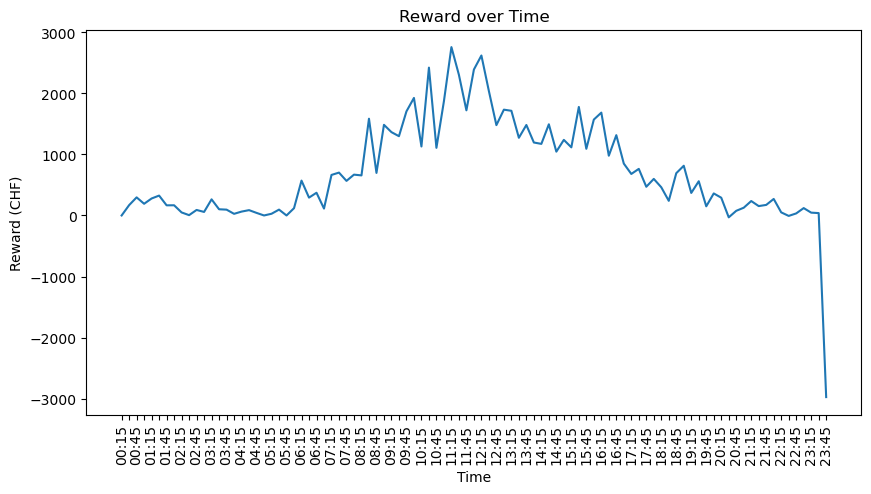

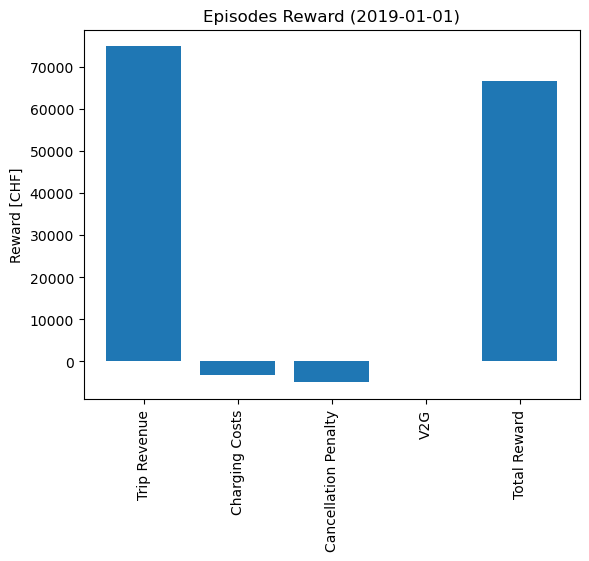

Total reward:
66737.3318974788

Total Episode Time:  18.7820463180542



In [40]:
# number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
env = CarsharingEnv(stations, vehicles, planned_bookings = True, plot_state = False, max_distance_car_assingment = 500, v2g_penalty = 0, v2g_reward=0)
    
count = 0

# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        start = time.time()
        start2 = time.time()
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date = pd.to_datetime(data.columns[day-97])
        
        
       
        # load reservations of current day, create indices
        sql = "SELECT reservation_no, start_station_no, syscreatedate_daytime, vehicle_no, reservationfrom_daytime, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km FROM msc_2023_dominik.reservations_discrete WHERE reservationfrom_discrete_date = '{}' or drive_firststart_discrete_date = '{}' ORDER BY reservationfrom_discrete".format(date, date)
        reservations = pd.read_sql(sql, engine)
        reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)
    
        end2 = time.time()
        print("Data loading: ", end2-start2)
        # get discete data of day
        daily_data = data.iloc[:,day-97:day]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        
        # reset day at begining of new episode (day)
        s = env.reset(daily_data, reservations, planned_reservations_day, planned_durations_day)
        
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, daily_data, done, _ = env.step(act, daily_data, reservations, electricity_price, planned_reservations_day, planned_durations_day)
            
            # get timestep statistics 
            env.render(daily_data)
            
            #print("Reward in this step:", rew, " time: ", env.t)
            counter +=1
        end = time.time()
        # summary statistics of episode (day)
        env.episode_summary_statistics(daily_data)
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        count += 1

In [ ]:
66775.60187412713
66775.60187412713

In [ ]:
changed_vehicles = {}
# car re-assignment: user wanted to book vehicle 1, but now assigned to vehicle 2. Booking is until time t.
changed_vehicles[1] = (station_no, t)
changed_vehicles[2] = (reservation_no, t)
# at each step:
daily_data = ...load discrete table
for veh_no, change in changed_vehicles.items():
     daily_data.loc[veh_no] = change[0]
     if current_time > change[1]:
          # delete change from dictionary because outdated
          del changed_vehicles[veh_no]

# Application of Enviorment 

### Load data for simulation

In [6]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex

# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)

### Create environment

The following code creates the simulation enviroment. The list below descripes all parameters that can be specified. For your task, it is important that "planned_bookings" is set to "False". You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

In [7]:
env = CarsharingEnv(stations, vehicles, planned_bookings = True, plot_state = False, max_distance_car_assingment = 500, v2g_penalty = 0, v2g_reward=0)

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
energy_prices = np.zeros(96)
energy_prices[:24] = 0.2
energy_prices[24:40] = 0.25
energy_prices[40:44] = 0.22
energy_prices[44:56] = 0.2
energy_prices[56:68] = 0.22
energy_prices[68:84] = 0.25
energy_prices[84:] = 0.22

electricity_price = energy_prices

# Your Task

In [9]:
def your_v2g_strategy(state, nr_vehicles):
        
    # get current locations of vehicles (station number, reservation number, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
        
    # check if V2G event will take place in the next timestep (0 = no V2G event, 1 = discharging event, 2 = charging event)
    soc_of_vehicles = state[nr_vehicles * 2:]
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    
    # dummy examples:
    # charge all vehicles
    #action = np.ones(nr_vehicles)
    
    # discharge all vehicles
    #action = np.full(nr_vehicles, 2)
    
    # do nothing
    action = np.zeros(nr_vehicles)
    
    # send action to enviroment
    return action
    
    

### Start simulation

Chose number of days to simulate. At the moment, the simulation will be execuded chronologically (first day: 1.1.2019, second day: 2.1.2019)

In [10]:
# number of days to simulate 
nr_iterations = 1

Start simulation: